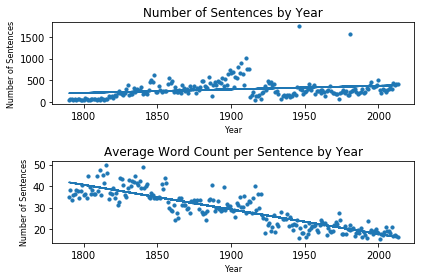

We notice that average number of words per sentence has been decreasing steadily over the course of US history.
However, the number of sentences rose dramatically around 1912 and then quickly dropped off.
This suggests that the number of total words in the SOU may have increased up until 1912 and then dropped off and stagnated until now.
This change was most likely caused by the development of the radio and other forms of mass media.
The following analysis confirms our intuition about total word count.


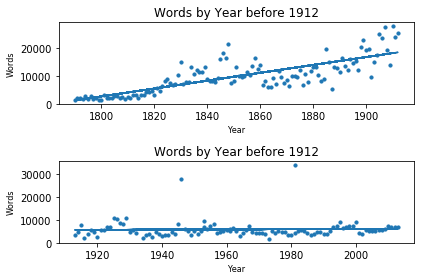

Longest sentences: James Madison
Shortest sentences: George Bush

Sentence Length Quantiles
0%: 16.7280453258
25%: 21.2338676531
50%: 30.3151292937
75%: 34.6037321625
100%: 43.0854870775

Longest Sentence:   Over the past 48 months, clear progress has been made in solving the challenges we found in January of 1977:   almost all of our comprehensive energy program have been enacted, and the Department of Energy has been established to administer the program;   confidence in the government's integrity has been restored, and respect for the government's openness and fairness has been renewed;   the government has been made more effective and efficient: the Civil Service system was completely reformed for the first time this century; 14 reorganization initiatives have been proposed to the Congress, approved, and implemented; two new Cabinet departments have been created to consolidate and streamline the government's handling of energy and education problems; inspectors general have been

In [10]:
from pyspark.sql import SparkSession
import numpy as np
import os
import re
import matplotlib.pyplot as plt


spark  = SparkSession.builder.master('local').appName('SOU').getOrCreate()
df = spark.read.json('/project/cmsc25025/sou/speeches.json')

#### Part A
'''
Also attempted using the following regex: r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s'
But I did not notice any noticeable differences.
'''
def parser(text):
    '''
    Parse's each row's text into sentences
    '''
    new_text = text.replace('\n', '').replace('\r', '').split('.')
    return new_text
    
def avgLenSen_year(row):
    '''
    Calculates the average number of words in a sentence per year. 
    Returns a triplet. 
    '''
    year = int(row['year'])
    new_row = parser(row['text'])
    num_sen = len(new_row)
    word_count = 0
    
    for sentence in new_row: 
        word_count += len(sentence.split())
    
    avg_sen = float(word_count) / float(num_sen)
    return (year, (num_sen, avg_sen))

data = df.rdd.map(avgLenSen_year).collect()

#### Part B
def create_vectors(data_points):
    '''
    Turns list of lists into three separate lists. 
    '''
    year_list = []
    sen_count_list = [] 
    sen_len_list = []
    
    for triplet in data_points: 
        year_list.append(triplet[0])
        sen_count_list.append(triplet[1][0])
        sen_len_list.append(triplet[1][1])
    return year_list, sen_count_list, sen_len_list

year_list, sen_count_list, sen_len_list = create_vectors(data)
year_array = np.array(year_list)
sen_count_array = np.array(sen_count_list)
sen_len_array = np.array(sen_len_list)

# Linear Regression Calculation
def calc_regression(indep_var_array, dep_var_array):
    '''
    Calculates the slope, intercept, and predicted values for a regression
    based on inputs.
    '''
    indep_avg = np.average(indep_var_array)
    dep_avg = np.average(dep_var_array)
    
    cov_matrix = np.cov(indep_var_array, dep_var_array)
    bhat = cov_matrix[1][0] / cov_matrix[0][0]
    b0 = dep_avg - (indep_avg * bhat) 
    
    yhat = (bhat * indep_var_array) + b0
    return bhat, b0, yhat
    
sen_count_bhat, sen_count_b0, sen_count_yhat = calc_regression(year_array, sen_count_array)
sen_len_bhat, sen_len_b0, sen_len_yhat = calc_regression(year_array, sen_len_array)

# Scatter Plots
plt.clf()
plt.figure(1)

plt.subplot(211)
plt.scatter(year_array, sen_count_array, s = 10)
plt.plot(year_array, sen_count_yhat, '-')
plt.title('Number of Sentences by Year', fontsize = 12)
plt.xlabel('Year', fontsize = 8)
plt.ylabel('Number of Sentences', fontsize = 8)

plt.subplot(212)
plt.scatter(year_array, sen_len_array, s = 10)
plt.plot(year_array, sen_len_yhat, '-')
plt.title('Average Word Count per Sentence by Year', fontsize = 12)
plt.xlabel('Year', fontsize = 8)
plt.ylabel('Number of Sentences', fontsize = 8)

plt.tight_layout()
plt.show()

# Explanation
print "We notice that average number of words per sentence has been decreasing steadily over the course of US history."
print "However, the number of sentences rose dramatically around 1912 and then quickly dropped off."
print "This suggests that the number of total words in the SOU may have increased up until 1912 and then dropped off and stagnated until now."
print "This change was most likely caused by the development of the radio and other forms of mass media."
print "The following analysis confirms our intuition about total word count."
#### Part C
year_post1912 = []
total_words_post1912 = []

year_pre1912 = []
total_words_pre1912 = []

#Calculates total words per year
for index, year in enumerate(year_list):
    if year > 1912:
        year_post1912.append(year_list[index])
        total_words_post1912.append(sen_count_list[index] * sen_len_list[index])
    else:
        year_pre1912.append(year_list[index])
        total_words_pre1912.append(sen_count_list[index] * sen_len_list[index])

year_pre1912 = np.array(year_pre1912)
year_post1912 = np.array(year_post1912)

# Pre 1912 Regression
pre1912_bhat, pre1912_b0, pre1912_yhat = calc_regression(year_pre1912, total_words_pre1912)

# Post 1912 Regression
post1912_bhat, post1912_b0, post1912_yhat = calc_regression(year_post1912, total_words_post1912)        

# Scatter Plots
plt.figure(2)

plt.subplot(211)
plt.scatter(year_pre1912, total_words_pre1912, s = 10)
plt.plot(year_pre1912, pre1912_yhat, '-')
plt.title('Words by Year before 1912', fontsize = 12)
plt.xlabel('Year', fontsize = 8)
plt.ylabel('Words', fontsize = 8)

plt.subplot(212)
plt.scatter(year_post1912, total_words_post1912, s = 10)
plt.plot(year_post1912, post1912_yhat, '-')
plt.title('Words by Year before 1912', fontsize = 12)
plt.xlabel('Year', fontsize = 8)
plt.ylabel('Words', fontsize = 8)

plt.tight_layout()
plt.show()


#### Part D
def avgLenSen_prez(row):
    '''
    Calculates average sentence length per president.
    Returns a tuple with president as the key.
    '''
    key = str(row['president'])
    new_row = parser(row['text'])
    num_sen = len(new_row)
    word_count = 0
    
    for sentence in new_row: 
        word_count += len(sentence.split())
    
    avg_sen = float(word_count) / float(num_sen)
    return (key, (num_sen, avg_sen))

def reduceAvgLenSen(x,y):
    '''
    Calculates the average sentence length based on two data points.
    '''
    num_sen = x[0] + y[0]
    avg_sen = ((float(x[0]) * float(x[1])) + (float(y[0]) * float(y[1]))) / (num_sen)
    return (num_sen, avg_sen)
    
president_sen_len =  df.rdd.map(avgLenSen_prez).reduceByKey(reduceAvgLenSen).collect()

# Longest and Shortest Avg Sentence
longest_sen = 0
shortest_sen = 1000000000
sen_lengths = []

for president_tuple in president_sen_len: 
    sen_lengths.append(president_tuple[1][1])
    if president_tuple[1][1] > longest_sen:
        longest_sen = president_tuple[1][1]
        president_long = president_tuple[0]
        
    if president_tuple[1][1] < shortest_sen:
        shortest_sen = president_tuple[1][1]
        president_short = president_tuple[0]
    
print "Longest sentences: " + president_long 
print "Shortest sentences: " + president_short
print

# Quantiles
percentiles = [0, 25, 50, 75, 100]
quantiles = np.percentile(np.array(sen_lengths), percentiles)
print "Sentence Length Quantiles"
for index, quantile in enumerate(quantiles):
    print str(percentiles[index]) + "%: " + str(quantile) 
print 


# Longest and Shortest Sentences
def senLen(row):
    key = row['president']
    new_row = parser(row['text'])
    word_count = 0
    sentence_tuples = []
    
    for sentence in new_row: 
        word_count = len(sentence.split())
        sentence_tuples.append((sentence, word_count))
    return sentence_tuples
    
sentences_by_len = [val for sublist in df.rdd.map(senLen).collect() for val in sublist]
sentences_by_len = sorted(sentences_by_len, key=lambda x: x[1])

# Longest Sentence
print "Longest Sentence: " + sentences_by_len.pop()[0]
print
# Shortest Sentence - which is a blank due to the splitting method
print "Shortest Sentence: " + sentences_by_len[0][0]

